
<img src="https://gitlab.com/bivl2ab/academico/cursos-uis/ai/ai-2-uis-student/-/raw/master/imgs/Banner_IA2_1.png" style="width:1500px;heigth:100px">


# <center> **UNET challenge** </center>


In [ ]:
#@title Insert your credentials
course_id = 'IA2-20222-J1' #@param {type:"string"}
student_id = '2218109' #@param {type:"string"}
assignment_id = f'{course_id}.acdc_segmentation_challenge'

In [ ]:
#@title **Execute this cell**
#@markdown **UTILS**
#@markdown Please dont modify any line in this cell
from IPython.display import clear_output

!pip install azure-storage-blob -qqq
clear_output()

import numpy as np
from google.colab import files
from collections import namedtuple
from configparser import ConfigParser
from azure.storage.blob import ContainerClient

import os
import requests

u = "https://drive.google.com/uc?id="
id = "11eL_0sH8Vqlc7bsw0sTWMgV49hrZYkSS"
Config = namedtuple('Config', ['server_name'])
config = Config(server_name='https://bivlabgrader.azurewebsites.net/api')


def serialize_masks(masks: np.ndarray, assignment_id: str, student_id: str):
    assert masks.shape == (80, 128, 128), "Masks should have shape (80, 128, 128)"
    assert np.array_equal(masks, masks.astype(bool)), f"Your masks contain non-binary values. Unique values {np.unique(masks)}"
    dest_dir = "ACDCHeartSegmentation_ytest"
    assignment_id = assignment_id.replace(".", "+")
    func_name = "acdc_segmentation_challenge"
    preds_save_path = f"{dest_dir} {assignment_id} {student_id} {func_name}.npy"
    np.save(preds_save_path, masks.astype(np.float32))
    return preds_save_path


def upload_file_to_blob(filepath: str, connection_string: str, container_name: str):
    %cd /content/
    clear_output()
    container_client = ContainerClient.from_connection_string(connection_string, container_name)
    blob_client = container_client.get_blob_client(filepath)
    with open(filepath, mode="rb") as data:
        print(f"Uploading predictions...")
        blob_client.upload_blob(data, overwrite=True)
        print(f"Successfully uploaded {os.path.basename(filepath)} predictions.")
    

def submit_acdc_masks(masks: np.ndarray, assignment_id: str, student_id: str):
    
    parser = ConfigParser()
    r = requests.get(u+id).content.decode('utf-8')

    c = {}
    parser.read_string(r)
    params = parser.items("s")
    for param in params: c[param[0]] = param[1]
    
    preds_save_path = serialize_masks(masks, assignment_id, student_id)
    upload_file_to_blob(preds_save_path, c['cs'], c['cn'])

def pprint_json_response(response, indent=0):
    """Pretty print the response."""
    for key, value in response.items():
        print('\t' * indent + str(key.capitalize()))

        # If dictionary, do a recurrent call.
        if isinstance(value, dict):
            pprint_json_response(value, indent + 1)
        else:
            # Enumerate elements if list.
            if isinstance(value, list):
                if len(value) == 1:
                    print('\t' * (indent + 1) + str(value[0]))
                else:
                    for i, e in enumerate(value, start=1):
                        print('\t' * (indent + 1) + f'{i}. {e}')
            else:
                print('\t' * (indent + 1) + str(value))

In [ ]:
#@title 1. MONTAR EL DRIVE  (If you are in in colab){ display-mode: "form" }
import os
from google.colab import drive
drive.mount('/content/drive')
# os.chdir('//content/drive/My Drive/Master/Contraprestación/')
print(os.getcwd())

Mounted at /content/drive
/content


In [ ]:
#@title Load libraries and remember to configurate notebook in GPU

import os
import cv2
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import json
import base64
from glob import glob

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.metrics import BinaryIoU
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

#**code UNET**

In [ ]:
#@title **code** This is a function to create the pair of UNET convolutions
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
  """Function to add 2 convolutional layers with the parameters passed to it"""
  # first layer
  x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
            kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
  if batchnorm:
      x = BatchNormalization()(x)
  x = Activation('relu')(x)

  # second layer
  x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
            kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
  if batchnorm:
      x = BatchNormalization()(x)
  x = Activation('relu')(x)

  return x

In [ ]:
#@title **code** Since we have the conv2d_block it is needded to obtain a nice UNET function
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
  # Contracting Path
  c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
  p1 = MaxPooling2D((2, 2))(c1)
  p1 = Dropout(dropout)(p1)

  c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
  p2 = MaxPooling2D((2, 2))(c2)
  p2 = Dropout(dropout)(p2)

  c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
  p3 = MaxPooling2D((2, 2))(c3)
  p3 = Dropout(dropout)(p3)

  c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
  p4 = MaxPooling2D((2, 2))(c4)
  p4 = Dropout(dropout)(p4)

  c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)

  # Expansive Path
  u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
  u6 = concatenate([u6, c4])
  u6 = Dropout(dropout)(u6)
  c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)

  u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
  u7 = concatenate([u7, c3])
  u7 = Dropout(dropout)(u7)
  c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)

  u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
  u8 = concatenate([u8, c2])
  u8 = Dropout(dropout)(u8)
  c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)

  u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
  u9 = concatenate([u9, c1])
  u9 = Dropout(dropout)(u9)
  c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)

  outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
  model = Model(inputs=[input_img], outputs=[outputs])
  return model

## **UNET CHALLENGE - ventricles segmentation**

A very important task is the automate heart ventricle detection and segmentation. The task of classify, identify and segment heart ventricles it is very important in many clinical task, such as, to quantify disorders, disease related with cancer, understand treatment responses, among much others.  The image data was taken from ["Automated Cardiac Diagnosis Challenge (ACDC)
MICCAI challenge 2017"](https://www.creatis.insa-lyon.fr/Challenge/acdc/)

<center> 
<img src="https://www.frontiersin.org/files/Articles/508599/fcvm-07-00025-HTML/image_m/fcvm-07-00025-g001.jpg" width="1000">
</center>

# Challenge

In [ ]:
#@title Download the train dataset
!gdown https://drive.google.com/uc?id=1Tl95fYud_XTRdGuEbtSnoOXHzdBYMNi7
!gdown https://drive.google.com/uc?id=1hAlHJlehUYy-eBdnu4Fd76ZR5F3ickDe

Downloading...
From: https://drive.google.com/uc?id=1Tl95fYud_XTRdGuEbtSnoOXHzdBYMNi7
To: /content/ACDCHeartSegmentation_ytrain.npy
100% 21.0M/21.0M [00:00<00:00, 38.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1hAlHJlehUYy-eBdnu4Fd76ZR5F3ickDe
To: /content/ACDCHeartSegmentation_xtrain.npy
100% 62.9M/62.9M [00:00<00:00, 167MB/s]


### Load the train dataset

Beware, the training images come in range $[0-1]$

In [ ]:
X_train_path = "/content/ACDCHeartSegmentation_xtrain.npy"
y_train_path = "/content/ACDCHeartSegmentation_ytrain.npy"
X_train, y_train = np.load(X_train_path), np.load(y_train_path)

print(f"X_train -> min: {X_train.min()}, max: {X_train.max()}")
print(f"y_train -> unique values: {np.unique(y_train)}")
print(X_train.shape, y_train.shape)

X_train -> min: 0.0, max: 1.0
y_train -> unique values: [0. 1.]
(320, 128, 128, 3) (320, 128, 128)


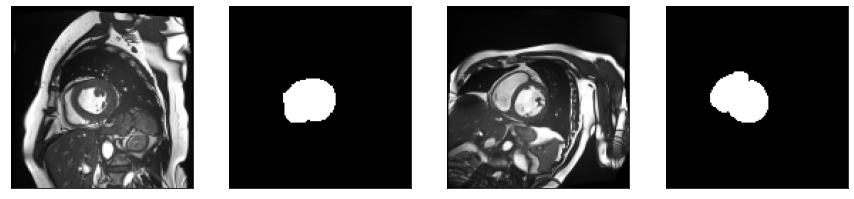

In [ ]:
#@title **Observe some sample images** index images between 0 -229. 
sample_1 = 0 #@param {type:"integer"}
sample_2 = 200 #@param {type:"integer"}
import matplotlib.pyplot as plt

plt.figure(figsize=(15,15))
plt.subplot(141), plt.imshow(X_train[sample_1]), plt.xticks([]), plt.yticks([]);
plt.subplot(142), plt.imshow(y_train[sample_1], cmap='gray'), plt.xticks([]), plt.yticks([]);
plt.subplot(143), plt.imshow(X_train[sample_2]), plt.xticks([]), plt.yticks([]);
plt.subplot(144), plt.imshow(y_train[sample_2], cmap='gray'), plt.xticks([]), plt.yticks([]);


## Segmentation network (U-Net)

Now we need to create, compile and tune the proposed model. 

💡 **Use the BinaryIoU metric to do a better monitoring of the training**

In [ ]:
input_img = Input((128, 128, 3), name='img')
model = get_unet(...)
model.compile(
    ..., 
    metrics=[BinaryIoU(target_class_ids=[1], threshold=0.5)]
)

## Segmentation network training

In [ ]:
results = model.fit(...)

## Experiment results validation

As a tip, plot the loss behavior and the metrics used to give you an idea of how the training of the model with the proposed approach turned out. Additionally, predict some segmentation masks using the trained model to infer what are the model strengths and weaknesses. 

> ❗ ***Remember to binarize the model predictions to visualize them properly***



### Loss and metrics plot

### Segmentation masks plot

## Predict on test samples

In [ ]:
#@title Download the test samples
!gdown https://drive.google.com/uc?id=107kHAVeJsEwASQaAZxqP5zPV7VEgrT_H

Downloading...
From: https://drive.google.com/uc?id=107kHAVeJsEwASQaAZxqP5zPV7VEgrT_H
To: /content/ACDCHeartSegmentation_xtest.npy
100% 15.7M/15.7M [00:00<00:00, 70.6MB/s]


### Load the test samples

Similar to `X_train`, `X_test` samples come in range $[0-1]$

In [ ]:
X_test_path = "/content/ACDCHeartSegmentation_xtest.npy"
X_test = np.load(X_test_path)

print(f"X_test shape -> {X_test.shape}")
print(f"X_test -> min: {X_test.min()}, max: {X_test.max()}")

X_test shape -> (80, 128, 128, 3)
X_test -> min: 0.0, max: 1.0


### Predict using the trained segmentation network

In [ ]:
preds_test = model.predict(...)

### Binarize the predictions

Use another threshold if you want, by default is set to `0.5`. Also, if you happened to use a model that outputs one-hot encoded predictions, make sure to replace the suggested binarization method below.

In [ ]:
masks_test = (preds_test > 0.5).astype(np.float32) 

## Submit your results

**❗IMPORTANT**: You should submit a numpy array with the **binarized masks**. The masks should have a shape of $(80, 128, 128)$, i.e. `masks_test.shape == (80, 128, 128)`. Otherwise, the evaluation will not happen.

In [ ]:
submit_acdc_masks(masks_test, assignment_id, student_id)

Uploading predictions...
Successfully uploaded ACDCHeartSegmentation_ytest IA2-20222-J1+acdc_segmentation_challenge 2218109 acdc_segmentation_challenge.npy predictions.


# Send the notebook and predictions via email

In [ ]:
#@title Save the notebook changes
%%javascript
require(["base/js/namespace"],function(Jupyter) {
    Jupyter.notebook.save_checkpoint();
});

<IPython.core.display.Javascript object>

In [ ]:
#@title Download your predictions
#@markdown Do not change the file name❗
%cd /content/
clear_output()

content = os.listdir("/content/")
preds_path = [p for p in content if student_id in p][0]
files.download(preds_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Send the email

Add your code as a prefix in the notebook name and follow `Archivo (File) > Descargar (Download) > Descargar .ipynb (Download .ipynb)`. You'll have your notebook and predictions ready to attach as an email to famarcar@saber.uis.edu.co. Best of luck!

**IMPORTANT:** Make sure the score appears on the notebook before sending it.

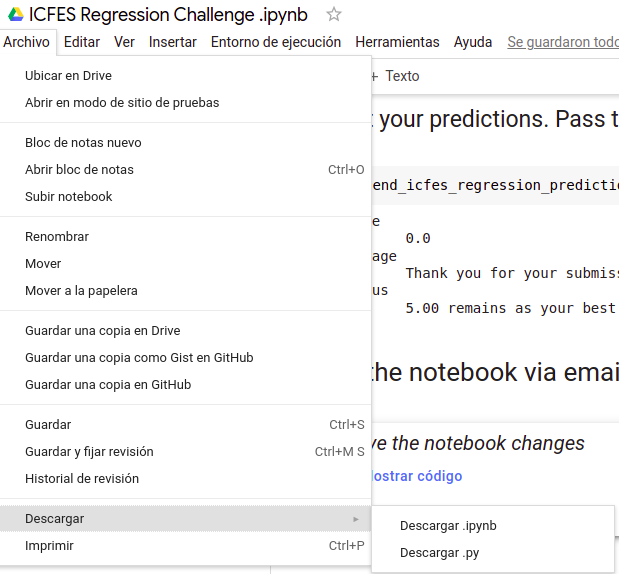

# Good luck!

<img src="https://gitlab.com/bivl2ab/academico/cursos-uis/ai/ai-uis-student/raw/master/imgs/bannerThanks.jpg" alt="Drawing" style="width:700px;">